In [1]:
setwd(paste0(Sys.getenv('R_SOURCES'), '/house_prices'))
getwd()

[1] "/mnt/hdd/develop/kaggle/R_sources/house_prices"

In [110]:
source('main.R')
house_prices$helpers$import_libs()

combined_dataset <-
    # load data
    house_prices$helpers$load_data() %>%
    #select(-one_of(house_prices$attributes_selection$discared_cat_vars)) %>%
    #select(-one_of(house_prices$attributes_selection$discared_num_vars)) %>%
    # remove outliers
    (house_prices$outliers$remove_outliers) %>%
    # fix NA values
    (house_prices$missing$categ$replace_with_most_common) %>%
    (house_prices$missing$categ$fix_valid) %>%
    (house_prices$missing$numeric$replace_with_zero) %>%
    mutate(
        price_log = log(SalePrice)
    ) %>%
    select(-SalePrice, -Id)

#####################
# transform numeric #
#####################

transformation_config <- house_prices$trans$numeric$get_transformation_config(combined_dataset)

transformation_config

combined_dataset <-
    house_prices$trans$numeric$apply_transform(combined_dataset, transformation_config)

#########################
# transform categorical #
#########################

combined_dataset <-
    house_prices$trans$categ$rating_transform(combined_dataset, price_log)

training_dataset <- combined_dataset %>% filter(dataSource == 'train') %>% select(-dataSource)

combined_dataset %>% head

var,predictor,score
BsmtUnfSF,sqrt,79.97603
GrLivArea,log,91.15794
LotArea,log,73.38993
TotRmsAbvGrd,log,30.68502
X1stFlrSF,log,90.77166


Alley,BldgType,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,CentralAir,Condition1,Condition2,⋯,OpenPorchSF,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,dataSource,price_log
2.531822,2.564039,2.540871,2.320042,3.262019,2.553429,3.066343,2.57887,2.547619,2.50277,⋯,61,0,0,0,0,0,2,2008,train,12.24769
2.531822,2.564039,2.540871,3.295455,2.231818,2.553429,3.066343,2.57887,1.987500,2.50277,⋯,0,0,0,0,0,0,5,2007,train,12.10901
2.531822,2.564039,2.540871,2.675439,3.262019,2.553429,3.066343,2.57887,2.547619,2.50277,⋯,42,0,0,0,0,0,9,2008,train,12.31717
2.531822,2.564039,3.046154,2.320042,2.231818,2.553429,1.847458,2.57887,2.547619,2.50277,⋯,35,272,0,0,0,0,2,2006,train,11.84940
2.531822,2.564039,2.540871,2.900452,3.262019,2.553429,3.066343,2.57887,2.547619,2.50277,⋯,84,0,0,0,0,0,12,2008,train,12.42922
2.531822,2.564039,2.540871,2.320042,3.262019,2.553429,3.066343,2.57887,2.547619,2.50277,⋯,30,0,320,0,0,700,10,2009,train,11.87060


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.7641906,0.7638664,0.194236,2357.618,0,3,321.8864,-635.7728,-614.6335,54.89371,1455


term,estimate,std.error,statistic,p.value
(Intercept),7.6588878,0.126036731,60.76711,0.000000e+00
GrLivArea,0.4565688,0.019430309,23.49777,9.051174e-104
OverallQual,0.1718658,0.004660648,36.87594,9.636469e-211


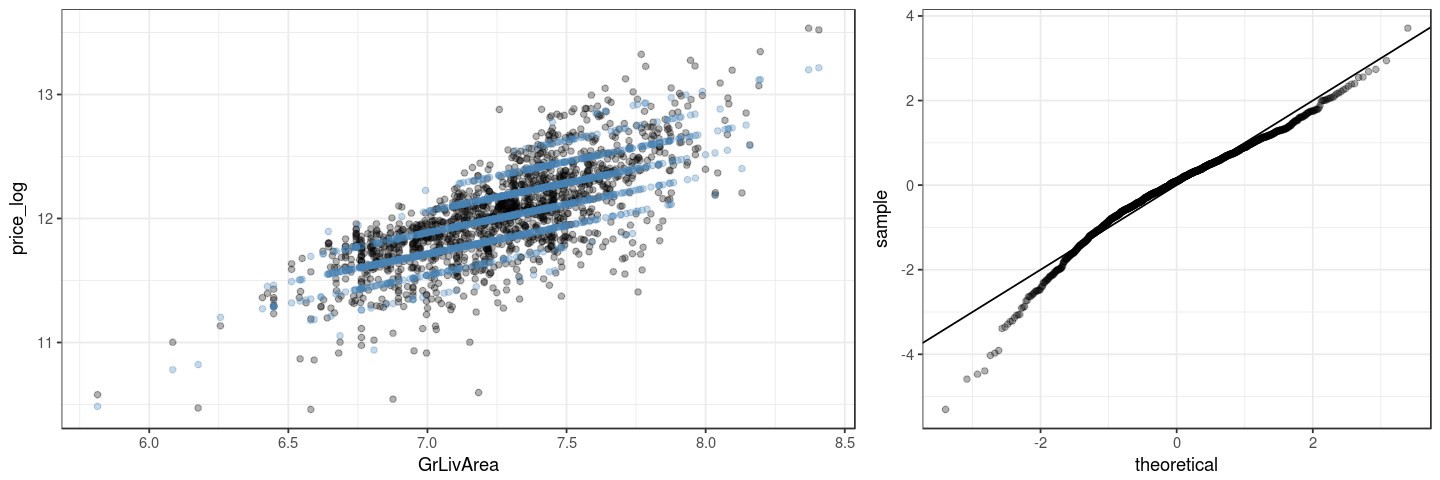

In [50]:
options(repr.plot.width = 12, repr.plot.height = 4)


mod <- lm(price_log ~ GrLivArea + OverallQual, data=training_dataset)

mod %>% glance
mod %>% tidy

plt_scatter <-
    mod %>%
    augment %>%
    ggplot() +
    geom_point(aes(x=GrLivArea, y=price_log), alpha=0.3) +
    geom_point(aes(x=GrLivArea, y=.fitted), alpha=0.3, color='steelblue') +
    theme_bw()

plt_qq <-
    mod %>%
    augment %>%
    select(resid=.resid) %>%
    mutate(
        resid_normed = (resid - mean(resid)) / sd(resid)
    ) %>%
    ggplot() +
    geom_qq(aes(sample=resid_normed), alpha=0.3) +
    geom_abline(slope=1, color="black") +
    theme_bw()

grid.arrange(
    plt_scatter, plt_qq, 
    layout_matrix=rbind(c(1, 2)), 
    widths=c(60, 40)
)

In [207]:
source('main.R')

report <- house_prices$model_selection$lm$greedy_r2_adj(
    'price_log ~ GrLivArea + OverallQual', 
    training_dataset,
    min_r2_gain = 0.5
)

report %>%
group_by(base_formula) %>%
top_n(1, r2_gain_adj)

base_formula,var_name,formula,base_r2,r2,r2_gain,max_corr,r2_gain_adj
price_log ~ GrLivArea + OverallQual,BsmtFinSF1,price_log ~ GrLivArea + OverallQual + BsmtFinSF1,0.7641906,0.8112984,6.1644091,0.2224668,5.0425982
price_log ~ GrLivArea + OverallQual + BsmtFinSF1,MSZoning,price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning,0.8112984,0.8362138,3.0710499,0.2709276,2.4163846
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning,SaleCondition,price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning + SaleCondition,0.8362138,0.8494706,1.5853383,0.3230405,1.1982537
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning + SaleCondition,CentralAir,price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning + SaleCondition + CentralAir,0.8494706,0.8582440,1.0328062,0.2725223,0.8116212
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning + SaleCondition + CentralAir,LotArea,price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning + SaleCondition + CentralAir + LotArea,0.8582440,0.8683040,1.1721625,0.3744884,0.8527992
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning + SaleCondition + CentralAir + LotArea,Functional,price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning + SaleCondition + CentralAir + LotArea + Functional,0.8683040,0.8726497,0.5004831,0.1621267,0.4306614


In [208]:
source('main.R')

base <- 'price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning + SaleCondition + CentralAir + LotArea + Functional'

report <- house_prices$model_selection$lm$greedy_r2_adj(
    base, 
    training_dataset,
    min_r2_gain = 0.4
)

report %>%
group_by(base_formula) %>%
top_n(1, r2_gain_adj)

base_formula,var_name,formula,base_r2,r2,r2_gain,max_corr,r2_gain_adj
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning + SaleCondition + CentralAir + LotArea + Functional,Condition1,price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning + SaleCondition + CentralAir + LotArea + Functional + Condition1,0.8726497,0.8767108,0.4653809,0.1566722,0.4023447
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning + SaleCondition + CentralAir + LotArea + Functional + Condition1,BsmtExposure,price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning + SaleCondition + CentralAir + LotArea + Functional + Condition1 + BsmtExposure,0.8767108,0.8805360,0.4363073,0.3760118,0.3170811
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning + SaleCondition + CentralAir + LotArea + Functional + Condition1 + BsmtExposure,OverallCond,price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning + SaleCondition + CentralAir + LotArea + Functional + Condition1 + BsmtExposure + OverallCond,0.8805360,0.8841112,0.4060217,0.1499247,0.3530855


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.8767108,0.8759445,0.1407858,1144.083,0,10,794.6368,-1567.274,-1509.14,28.70029,1448


term,estimate,std.error,statistic,p.value
(Intercept),5.6422226060,1.349514e-01,41.809278,3.249780e-251
GrLivArea,0.4302748022,1.536339e-02,28.006500,2.745485e-138
OverallQual,0.1251284998,3.842621e-03,32.563318,5.559090e-175
BsmtFinSF1,0.0001665721,8.997639e-06,18.512866,7.630781e-69
MSZoning,0.0791642654,8.720091e-03,9.078376,3.507031e-19
SaleCondition,0.1328006836,1.097867e-02,12.096240,3.708322e-32
CentralAir,0.1337458633,1.263487e-02,10.585459,2.839962e-25
LotArea,0.0926894848,8.257938e-03,11.224290,4.310440e-28
Functional,0.1781698665,2.388606e-02,7.459158,1.494061e-13
Condition1,0.1070586743,1.550157e-02,6.906311,7.423790e-12


,GrLivArea,OverallQual,BsmtFinSF1,MSZoning,SaleCondition,CentralAir,LotArea,Functional,Condition1
GrLivArea,1.00000000,0.6088750,0.13001367,0.19115415,0.15633902,0.12968957,0.37448836,-0.04907059,0.07730048
OverallQual,0.60887495,1.0000000,0.22246684,0.27092763,0.32304052,0.27252235,0.16755253,0.16212673,0.15667215
BsmtFinSF1,0.13001367,0.2224668,1.00000000,0.17345734,0.01945481,0.17255361,0.20564233,0.05519827,0.07278756
MSZoning,0.19115415,0.2709276,0.17345734,1.00000000,0.16543092,0.25643979,0.31928486,0.06184344,0.14630508
SaleCondition,0.15633902,0.3230405,0.01945481,0.16543092,1.00000000,0.10467089,0.05793143,0.07517848,0.07438929
CentralAir,0.12968957,0.2725223,0.17255361,0.25643979,0.10467089,1.00000000,0.05691857,0.07424332,0.06121303
LotArea,0.37448836,0.1675525,0.20564233,0.31928486,0.05793143,0.05691857,1.00000000,-0.03970457,0.01969060
Functional,-0.04907059,0.1621267,0.05519827,0.06184344,0.07517848,0.07424332,-0.03970457,1.00000000,-0.01099063
Condition1,0.07730048,0.1566722,0.07278756,0.14630508,0.07438929,0.06121303,0.01969060,-0.01099063,1.00000000


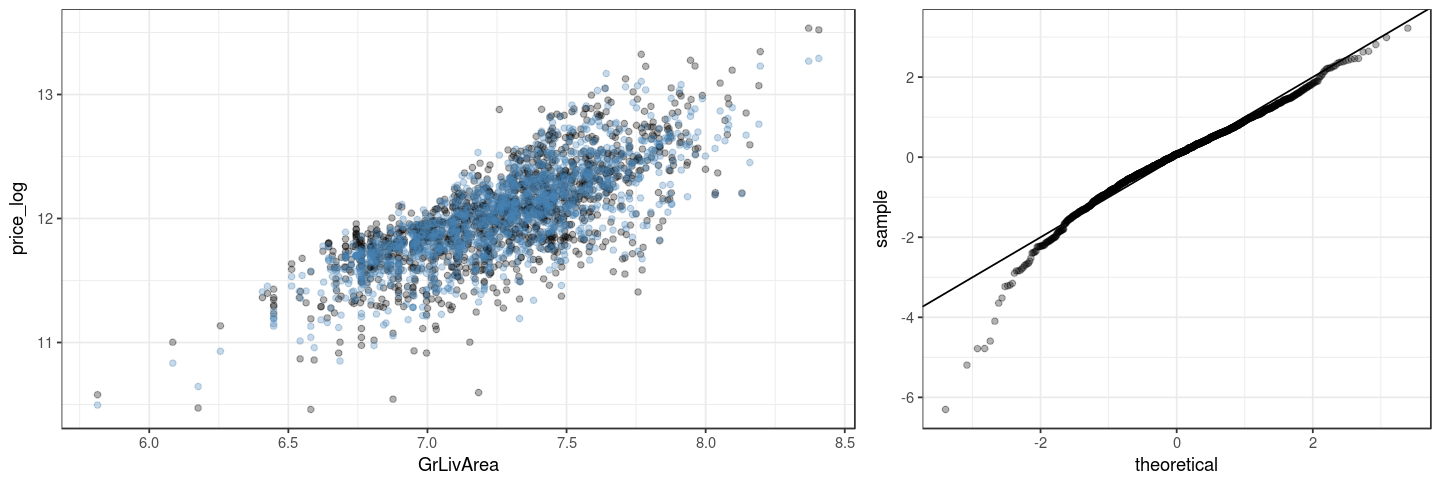

In [222]:
options(repr.plot.width = 12, repr.plot.height = 4)

mod <- lm(
    price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning + SaleCondition + CentralAir + LotArea + Functional + Condition1,
    data=training_dataset
)

mod %>% glance
mod %>% tidy
cor(training_dataset[setdiff(names(mod$coefficients), '(Intercept)')])

plt_scatter <-
    mod %>%
    augment %>%
    ggplot() +
    geom_point(aes(x=GrLivArea, y=price_log), alpha=0.3) +
    geom_point(aes(x=GrLivArea, y=.fitted), alpha=0.3, color='steelblue') +
    theme_bw()

plt_qq <-
    mod %>%
    augment %>%
    select(resid=.resid) %>%
    mutate(
        resid_normed = (resid - mean(resid)) / sd(resid)
    ) %>%
    ggplot() +
    geom_qq(aes(sample=resid_normed), alpha=0.3) +
    geom_abline(slope=1, color="black") +
    theme_bw()

grid.arrange(
    plt_scatter, plt_qq, 
    layout_matrix=rbind(c(1, 2)), 
    widths=c(60, 40)
)

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.8927447,0.8919288,0.1314032,1094.168,0,12,896.2014,-1766.403,-1697.7,24.96779,1446


term,estimate,std.error,statistic,p.value
(Intercept),6.2485092870,1.325510e-01,47.140433,1.351526e-294
GrLivArea,0.3961203035,1.456891e-02,27.189423,7.884859e-132
OverallQual,0.0949619803,4.160368e-03,22.825380,9.792318e-99
BsmtFinSF1,0.0001532114,8.449313e-06,18.133006,2.249975e-66
MSZoning,0.0367947637,9.133474e-03,4.028562,5.903576e-05
SaleCondition,0.1035802151,1.043942e-02,9.922023,1.714547e-22
CentralAir,0.1241152199,1.182793e-02,10.493403,7.067559e-25
LotArea,0.0787645133,7.770162e-03,10.136792,2.243932e-23
Functional,0.1550238900,2.237086e-02,6.929725,6.329933e-12
Condition1,0.0907198051,1.453826e-02,6.240071,5.733247e-10


,GrLivArea,OverallQual,BsmtFinSF1,MSZoning,SaleCondition,CentralAir,LotArea,Functional,Condition1,Neighborhood,GarageCars
GrLivArea,1.00000000,0.6088750,0.13001367,0.19115415,0.15633902,0.12968957,0.37448836,-0.04907059,0.07730048,0.4674791,0.49675514
OverallQual,0.60887495,1.0000000,0.22246684,0.27092763,0.32304052,0.27252235,0.16755253,0.16212673,0.15667215,0.6790092,0.60074082
BsmtFinSF1,0.13001367,0.2224668,1.00000000,0.17345734,0.01945481,0.17255361,0.20564233,0.05519827,0.07278756,0.2426179,0.22907701
MSZoning,0.19115415,0.2709276,0.17345734,1.00000000,0.16543092,0.25643979,0.31928486,0.06184344,0.14630508,0.5438355,0.25811189
SaleCondition,0.15633902,0.3230405,0.01945481,0.16543092,1.00000000,0.10467089,0.05793143,0.07517848,0.07438929,0.3284304,0.30280627
CentralAir,0.12968957,0.2725223,0.17255361,0.25643979,0.10467089,1.00000000,0.05691857,0.07424332,0.06121303,0.2631064,0.23360797
LotArea,0.37448836,0.1675525,0.20564233,0.31928486,0.05793143,0.05691857,1.00000000,-0.03970457,0.01969060,0.2846679,0.27030333
Functional,-0.04907059,0.1621267,0.05519827,0.06184344,0.07517848,0.07424332,-0.03970457,1.00000000,-0.01099063,0.1546109,0.09039717
Condition1,0.07730048,0.1566722,0.07278756,0.14630508,0.07438929,0.06121303,0.01969060,-0.01099063,1.00000000,0.2032753,0.11505300
Neighborhood,0.46747905,0.6790092,0.24261785,0.54383547,0.32843038,0.26310638,0.28466787,0.15461093,0.20327531,1.0000000,0.57927813


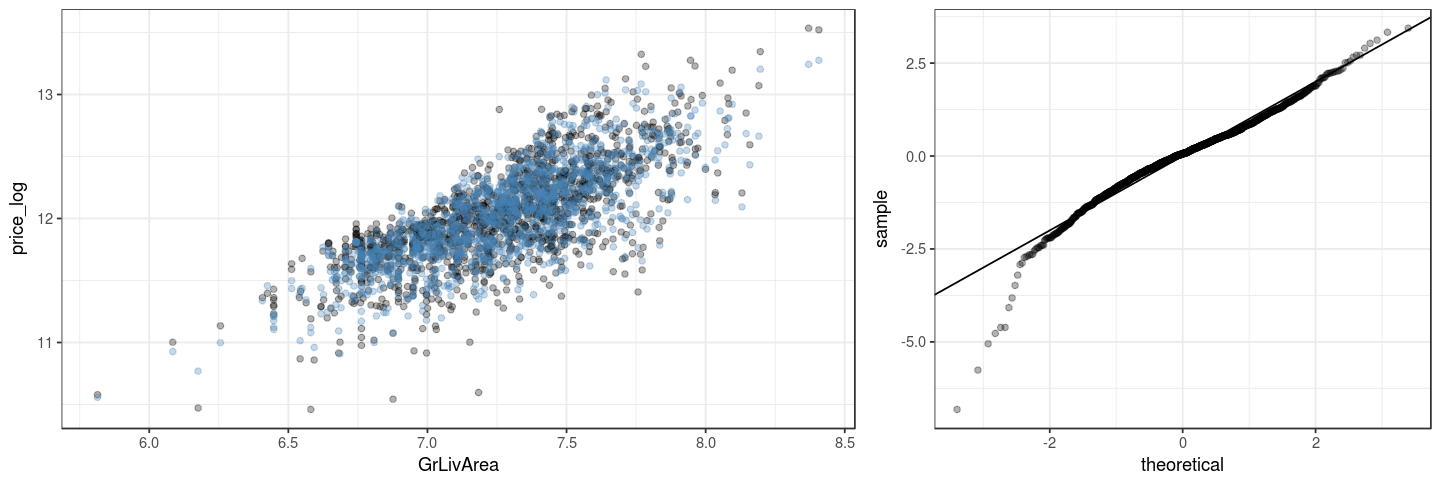

In [224]:
options(repr.plot.width = 12, repr.plot.height = 4)

mod <- lm(
    price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning + SaleCondition + CentralAir + LotArea + Functional + Condition1 + Neighborhood + GarageCars,
    data=training_dataset
)

mod %>% glance
mod %>% tidy
cor(training_dataset[setdiff(names(mod$coefficients), '(Intercept)')])

plt_scatter <-
    mod %>%
    augment %>%
    ggplot() +
    geom_point(aes(x=GrLivArea, y=price_log), alpha=0.3) +
    geom_point(aes(x=GrLivArea, y=.fitted), alpha=0.3, color='steelblue') +
    theme_bw()

plt_qq <-
    mod %>%
    augment %>%
    select(resid=.resid) %>%
    mutate(
        resid_normed = (resid - mean(resid)) / sd(resid)
    ) %>%
    ggplot() +
    geom_qq(aes(sample=resid_normed), alpha=0.3) +
    geom_abline(slope=1, color="black") +
    theme_bw()

grid.arrange(
    plt_scatter, plt_qq, 
    layout_matrix=rbind(c(1, 2)), 
    widths=c(60, 40)
)